In [1]:
import os
from pathlib import Path
current_directory = Path().resolve()
os.chdir(Path(current_directory).resolve().parent.parent)

import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import chardet

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = False

file_path = current_directory / "conversion_df.csv"

if not file_path.exists():
    raise Exception(f"File {file_path} does not exist.")

with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

df = pd.read_csv(file_path, encoding=file_encoding, sep=',')

df.head()

,temperature,rate_3_diff_reaction_0_conversion,rate_3_diff_reaction_1_conversion,rate_3_diff_reaction_2_conversion,rate_3_diff_reaction_3_conversion,rate_5_diff_reaction_0_conversion,rate_5_diff_reaction_1_conversion,rate_5_diff_reaction_2_conversion,rate_5_diff_reaction_3_conversion,rate_10_diff_reaction_0_conversion,rate_10_diff_reaction_1_conversion,rate_10_diff_reaction_2_conversion,rate_10_diff_reaction_3_conversion
0,30.27800,9.827818e-08,9.972903e-14,1.085497e-95,4.368624e-31,1.631908e-08,1.548049e-12,9.211130e-119,4.843107e-36,2.327450e-08,7.123818e-12,6.808762e-155,2.411354e-26
1,31.23291,2.018687e-07,2.095083e-13,3.233271e-95,9.677860e-31,3.357247e-08,3.220325e-12,2.961691e-118,1.081627e-35,4.776307e-08,1.474954e-11,2.450654e-154,5.173075e-26
2,32.18783,3.111036e-07,3.302654e-13,7.470771e-95,1.613673e-30,5.182243e-08,5.035938e-12,7.472155e-118,1.820201e-35,7.349531e-08,2.290955e-11,7.056580e-154,8.346994e-26
3,33.14274,4.263148e-07,4.630829e-13,1.585870e-94,2.399608e-30,7.113127e-08,6.994890e-12,1.749843e-117,2.734337e-35,1.005601e-07,3.165242e-11,1.899695e-153,1.199494e-25
4,34.09766,5.478344e-07,6.091975e-13,3.248944e-94,3.352762e-30,9.156127e-08,9.129032e-12,3.969752e-117,3.864396e-35,1.290165e-07,4.101052e-11,5.003689e-153,1.615813e-25


<Axes: xlabel='conversion'>

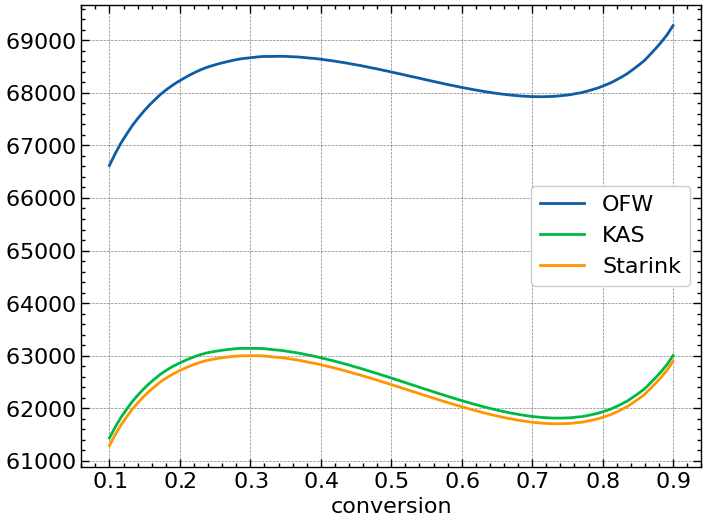

In [2]:
import numpy as np
import scipy.stats as stats
from scipy.constants import R
from scipy.interpolate import interp1d

ALPHA_MIN = 0.1 # Минимальная конверсия
ALPHA_MAX = 0.9 # Максимальная конверсия

reaction_cols = ["rate_3_diff_reaction_0_conversion", "rate_5_diff_reaction_0_conversion", "rate_10_diff_reaction_0_conversion",]
_df = df[[*reaction_cols]].copy()
dadt_data = [_df[col].diff() for col in _df]
reaction_df = pd.DataFrame(dadt_data).T
reaction_df["temperature"] = df["temperature"]
reaction_df.columns = ["3", "5", "10", "temperature"]

def fetch_linear_approx_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    conv = reaction_df[rate_cols].cumsum() / reaction_df[rate_cols].cumsum().max()
    temperature = reaction_df["temperature"]

    valid = temperature.notna() & conv.notna().all(axis=1)
    conv, temperature = conv[valid], temperature[valid]

    f = {rate: interp1d(conv[rate], temperature, bounds_error=False, fill_value="extrapolate")
         for rate in rate_cols}

    lower_bound = max(conv.min().min(), ALPHA_MIN)
    upper_bound = min(conv.max().max(), ALPHA_MAX)

    conv_grid = np.linspace(lower_bound, upper_bound, 100)

    T = np.column_stack([f[rate](conv_grid) for rate in rate_cols]) + 273.15
    X = 1.0 / T
    x_mean = X.mean(axis=1, keepdims=True)
    denom = ((X - x_mean) ** 2).sum(axis=1)

    rates = np.array([float(rate) for rate in rate_cols])
    log_rates = np.log(rates)

    # OFW: y = ln(β)
    Y_OFW = np.tile(log_rates, (100, 1))
    slope_OFW = ((X - x_mean) * (Y_OFW - Y_OFW.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    # KAS: y = ln(β) - 2·ln(T)
    Y_KAS = log_rates - 2 * np.log(T)
    slope_KAS = ((X - x_mean) * (Y_KAS - Y_KAS.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    # Starink: y = ln(β) - 1.92·ln(T)
    Y_Starink = log_rates - 1.92 * np.log(T)
    slope_Starink = ((X - x_mean) * (Y_Starink - Y_Starink.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    Ea_OFW = slope_OFW * R / -1.052
    Ea_KAS = slope_KAS * R / -1.0
    Ea_Starink = slope_Starink * R / -1.008

    return pd.DataFrame({
        "conversion": conv_grid,
        "OFW": Ea_OFW,
        "KAS": Ea_KAS,
        "Starink": Ea_Starink
    })

result_df = fetch_linear_approx_Ea(reaction_df)

result_df.plot(x="conversion")


<Axes: xlabel='conversion'>

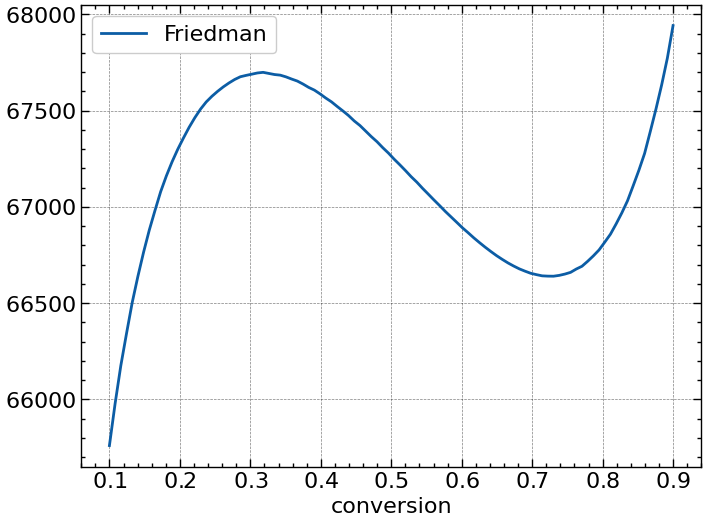

In [4]:
def fetch_friedman_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    conv = reaction_df[rate_cols].cumsum() / reaction_df[rate_cols].cumsum().max()
    temperature = reaction_df["temperature"]

    valid = temperature.notna() & conv.notna().all(axis=1)
    conv, temperature = conv[valid], temperature[valid]

    f = {
        rate: interp1d(conv[rate], temperature, bounds_error=False, fill_value="extrapolate")
        for rate in rate_cols
    }

    lower_bound = max(conv.min().min(), ALPHA_MIN)
    upper_bound = min(conv.max().max(), ALPHA_MAX)
    conv_grid = np.linspace(lower_bound, upper_bound, 100)

    T = np.column_stack([f[rate](conv_grid) for rate in rate_cols]) + 273.15
    X = 1.0 / T

    x_mean = X.mean(axis=1, keepdims=True)
    denom = ((X - x_mean) ** 2).sum(axis=1)

    rates = np.array([float(rate) for rate in rate_cols])
    log_rates = np.log(rates)  # ln(β)

    # ln(dα/dT) = ln(β) - ln(T)
    Y_Friedman = np.tile(log_rates, (len(conv_grid), 1)) - np.log(T)
    slope_Friedman = ((X - x_mean) * (Y_Friedman - Y_Friedman.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    Ea_Friedman = -slope_Friedman * R

    return pd.DataFrame({
        "conversion": conv_grid,
        "Friedman": Ea_Friedman
    })

result_df = fetch_friedman_Ea(reaction_df)

result_df.plot(x="conversion")

In [6]:
def fetch_kissinger_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    temperature_K = reaction_df["temperature"] + 273.15

    peak_points = []
    for col in rate_cols:
        series = reaction_df[col]

        valid = series.notna() & temperature_K.notna()
        if valid.sum() == 0:
            continue

        cum = series[valid].cumsum()
        conv = cum / cum.iloc[-1]

        idx_peak = series.idxmax()
        T_peak = temperature_K.loc[idx_peak]
        alpha_peak = conv.loc[idx_peak]
        beta_val = float(col)
        peak_points.append((beta_val, T_peak, alpha_peak))

    peak_points.sort(key=lambda x: x[2])

    beta_vals = np.array([pt[0] for pt in peak_points], dtype=float)
    T_peaks = np.array([pt[1] for pt in peak_points], dtype=float)
    alphas = np.array([pt[2] for pt in peak_points], dtype=float)
    
    # X = 1/Tₚ, Y = ln(β / Tₚ²)
    X = 1.0 / T_peaks
    Y = np.log(beta_vals / (T_peaks ** 2))
    slope, intercept = np.polyfit(X, Y, 1)
    E_a = -slope * R

    result_df = pd.DataFrame({
        "conversion": alphas,
        "Kissinger_Ea": [E_a] * len(alphas)
    })
    return result_df

result_df = fetch_kissinger_Ea(reaction_df)

result_df

,conversion,Kissinger_Ea
0,0.654178,57500.04117
1,0.657866,57500.04117
2,0.700434,57500.04117
